# King County Housing Data Project
---
Student name: T.J. Kyner \
Student pace: Full time \
Instructor name: Abhineet Kulkarni \
Cohort: 040521

## Business Problem
---
The ability to accurately appraise a house is of critical importance for a variety of stakeholders. In addition to buyers and sellers, which each have their own interests in finding the fair market price of a house, other entities such as municipalities benefit from such insight as well. Given that property taxes provide the vast majority of tax revenue for municipalities, having an accurate prediction model for house prices can play a key role in efficient financial planning and budgeting. The goal of this project is to provide such a prediction model for the benefit of municipalities in King County, Washington. 

## Imports & Settings
---

In [1]:
# Core tools
import numpy as np
import pandas as pd

# Visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modeling tools
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler

Setting the default styling theme for seaborn:

In [2]:
sns.set_theme()

The following code forces tables written in Markdown to be aligned to the left of the cell instead of the center which is the default:

In [3]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

Pulling in the data to a DataFrame:

In [4]:
df = pd.read_csv('data/kc_house_data.csv')

## Exploratory Data Analysis
---

### Summary Statistics and Information
To start, I'll print the first five rows of the dataframe to get a quick feel for the information available.

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


While most of the 21 columns of data available are fairly self-explanatory, some require a bit more explanation. Along with the original dataset, some metadata on the column names was also provided. Brief descriptions of each column are as follows:

| Column | Description |
| ------ | ----------- |
| `id` | unique identified for a house|
| `date` | house was sold |
| `price` |  is prediction target |
| `bedrooms` |  of Bedrooms/House |
| `bathrooms` |  of bathrooms/bedrooms |
| `sqft_living` |  footage of the home |
| `sqft_lot` |  footage of the lot |
| `floors` |  floors (levels) in house |
| `waterfront` | House which has a view to a waterfront |
| `view` | Has been viewed |
| `condition` | How good the condition is (Overall) |
| `grade` | overall grade given to the housing unit, based on King County grading system |
| `sqft_above` | square footage of house apart from basement |
| `sqft_basement` | square footage of the basement |
| `yr_built` | Built Year |
| `yr_renovated` | Year when house was renovated |
| `zipcode` | zip |
| `lat` | Latitude coordinate |
| `long` | Longitude coordinate |
| `sqft_living15` | The square footage of interior housing living space for the nearest 15 neighbors |
| `sqft_lot15` | The square footage of the land lots of the nearest 15 neighbors |

Expanded definitions for certain columns, such as `condition` and `grade`, can be found within King County's [Residential Glossary of Terms](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r).

While most of the provided descriptions seem logical, I do have a concern regarding the `view` column. It seems more logical for this column to be referring to some sort of grading scale for the view available from the house rather than if it has been "viewed" (by whom? for what purpose?). This idea is further supported by "Views" being defined in King County's [Condo Glossary of Terms](https://info.kingcounty.gov/assessor/esales/Glossary.aspx#views) as follows:
> For each classification will display blank for no view or "Fair", "Average", "Good" or "Excellent" to reflect the quality of view for that unit

Next, I'll take a look at the datatypes for each column by calling the `.info()` method.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

**Observations:**
- The `date` column is stored as a string instead of a datetime object. The date down to the specific day is likely too granular to be useful. Using just the month and year may provide better results. This needs to be explored further.
- The `sqft_basement` column is stored as a string instead of an integer like all other columns regarding square footage.
- The `yr_renovated` column is stored as a float and should be converted to an integer since it is referring to a year.
- The `view`, `condition`, `grade`, and `zipcode` columns represent categorical data. These will need to be dealt with accordingly.

In addition to the above observations, it appears that some columns were missing data. Viewing this in an easier to digest manner yields the following:

In [7]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [8]:
print('Total rows:', df.shape[0])

Total rows: 21597


It appears that the `waterfront` and `yr_renovated` columns have a decent amount of values missing with the `view` column missing a negligible amount.

In [9]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


**Observations:**
- There appears to be an outlier with regard to `bedrooms` - the 75th percentile value is 4 bedrooms while the max is 33. This row may possibly need removed.
- The `yr_renovated` column appears to have a large number of `0` values which doesn't make sense given the context. This will be further explored with the `.value_counts()` method.

### Value Counts
While I already checked the number of missing values in each column, that does not always paint the full picture. As noted above, the `0` values in the `yr_renovated` column are one such instance where the values may not be missing but are nonetheless innaccurate and simply placeholders. Below, I'll loop over the top five values by frequency for each column as a way to check for any additional placeholder values that may not be readily apparent through summary statistics.

In [10]:
for col in df.columns:
    print('--- ', col.upper(), ' ---')
    print(df[col].value_counts(normalize=True).head(), '\n\n')

---  ID  ---
795000620     0.000139
1825069031    0.000093
2019200220    0.000093
7129304540    0.000093
1781500435    0.000093
Name: id, dtype: float64 


---  DATE  ---
6/23/2014    0.006575
6/25/2014    0.006066
6/26/2014    0.006066
7/8/2014     0.005880
4/27/2015    0.005834
Name: date, dtype: float64 


---  PRICE  ---
350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
Name: price, dtype: float64 


---  BEDROOMS  ---
3    0.454878
4    0.318655
2    0.127796
5    0.074131
6    0.012594
Name: bedrooms, dtype: float64 


---  BATHROOMS  ---
2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
Name: bathrooms, dtype: float64 


---  SQFT_LIVING  ---
1300    0.006390
1400    0.006251
1440    0.006158
1660    0.005973
1010    0.005973
Name: sqft_living, dtype: float64 


---  SQFT_LOT  ---
5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
7500    0.005510
Name: sqft_lot, dtype: flo

**Observations:**
- The `id` column has values that have higher frequencies than 1, indicating that there may either be duplicate rows or the dataset contains entries for each time a house is sold. Regardless, this column does not provide much information and can be dropped.
- Over 99% of houses are not specified as a waterfront property.
- Over 90% of houses do not have a view that warrants a grade.
- Around 2% of houses have `?` as a value for `sqft_basement` which appears to be a placeholder value. These will need to be dealt with but the existence of such a placeholder value bolsters confidence in the nearly 60% of homes with a value of `0.0`  for `sqft_basement` meaning that they truly have no basement (versus `0.0` also potentially being a placeholder value).
- Over 95% of houses have a `yr_renovated` value of `0.0`. As mentioned previously, the context indicates that this is meant as a placeholder value. Combined with the fact that this column has the largest amount of missing data, I will likely be dropping it.

### Basic Visualizations
Plotting each of the columns against `price` will allow me to quickly see which features are most correlated with the value of a house.

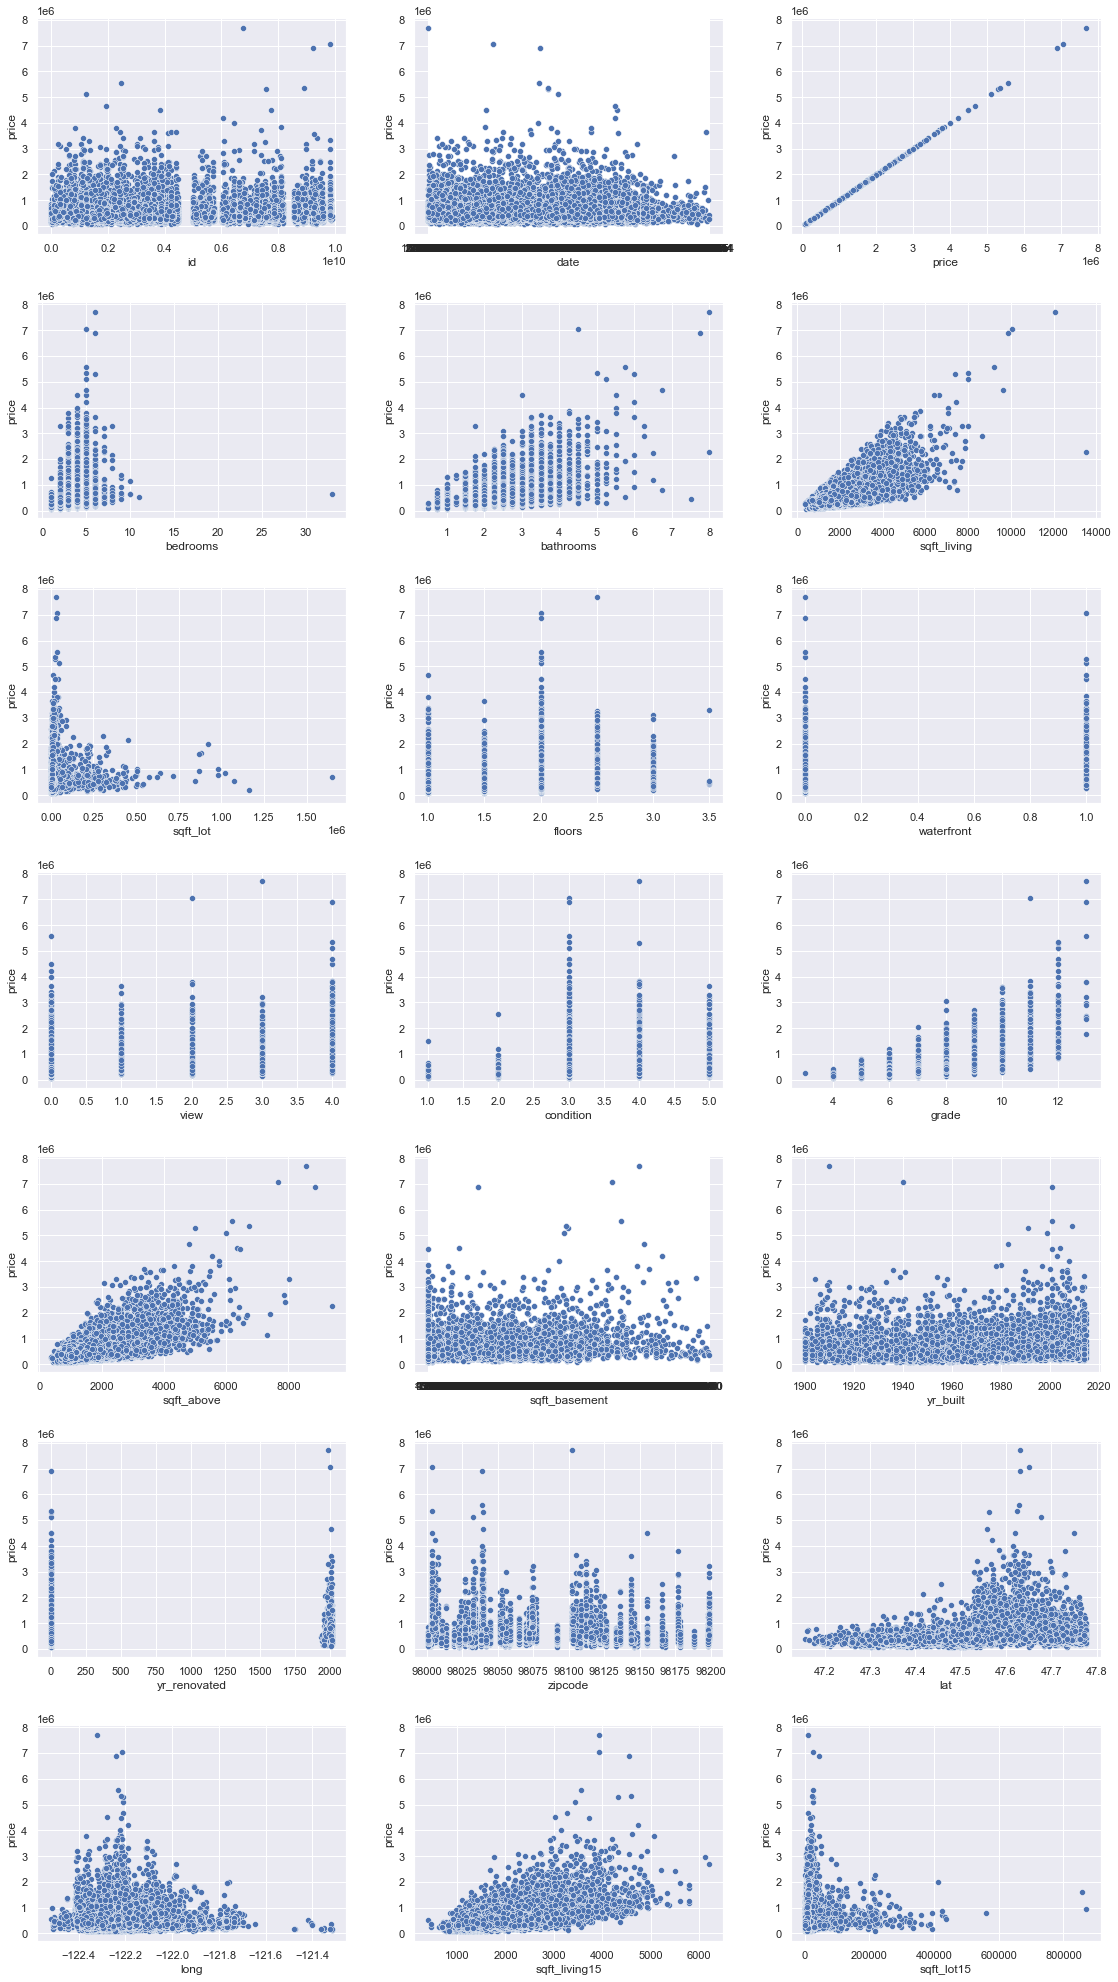

In [11]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(16, 28))
# Reshaping axes to a 1-D object for easier iteration
axes = axes.reshape(-1)

for i, col in enumerate(df.columns):
    sns.scatterplot(x=col, y='price', data=df, ax=axes[i])

# Increasing the padding around each subplot for enhanced clarity
fig.tight_layout(pad=2.0);

**Observations:**
- Unsurprisingly, the size of the home appears to be strongly correlated with `price`.
- Interestingly, houses with the highest `condition` do not seem to fetch higher average prices than those closer to the middle of the scale. 
- Both `waterfront` and `view` appear to have no correlation with `price`.

Next, I'll visualize the actual correlation values via a heatmap:

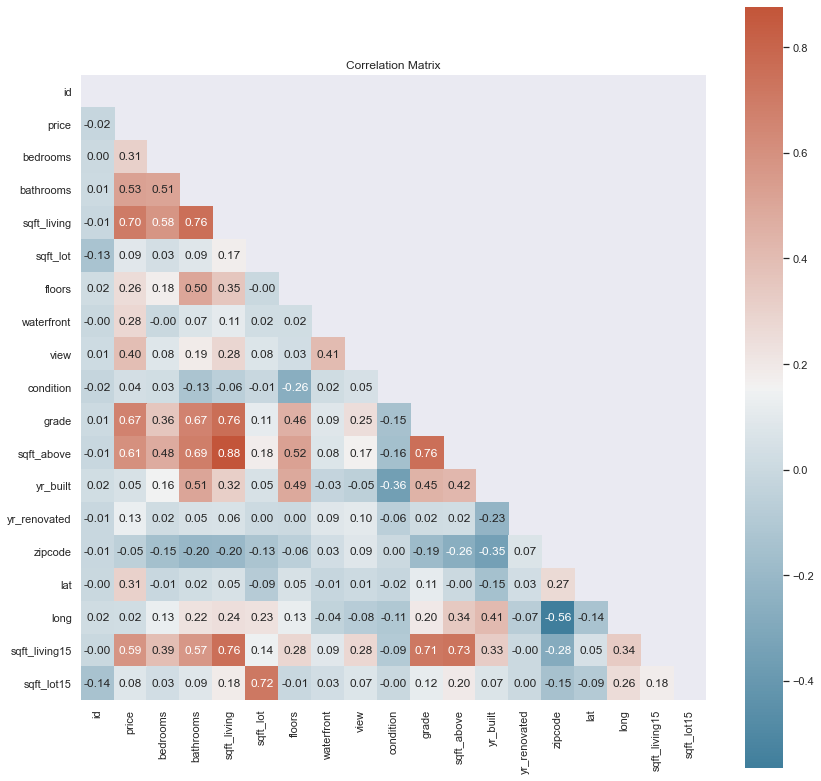

In [12]:
plt.figure(figsize=(14, 14))
plt.title('Correlation Matrix')

# Creating a mask to block the top right half of the heatmap (redundant information)
mask = np.triu(np.ones_like(df.corr()))

# Custom color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.2f', square=True, cmap=cmap);

**Observations:**
- Several columns are highly correlated with one another which will lead to multicollinearity issues in the regression models. This will need to be addressed.

Finally, I'll create a rough map using the latitude and longitude data.

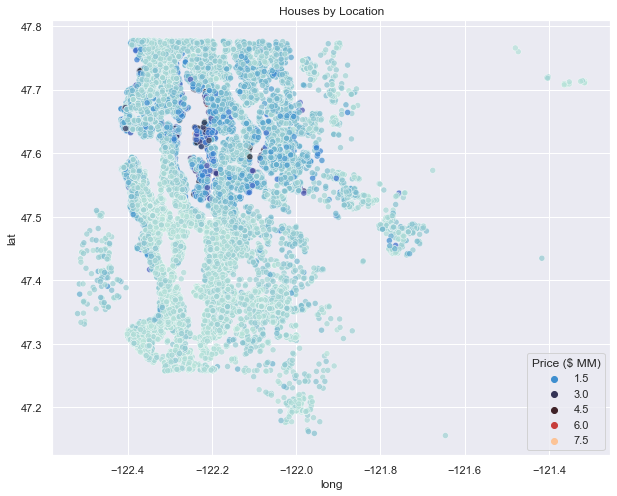

In [13]:
plt.figure(figsize=(10, 8))
plt.title('Houses by Location')
sns.scatterplot(data=df, x='long', y='lat', hue='price', alpha=0.7, palette='icefire')
plt.legend(title='Price ($ MM)', loc='lower right')
plt.savefig('images/map.png', dpi=150, facecolor='white');

**Observations:**
- Certain areas have a higher density of highly priced homes than others
- This indicates that `lat` and `long` will likely be useful predictors

## Data Preprocessing
---
Based on the observations made in the EDA section, the following list represents the goals for preprocessing the data before moving on to creating the baseline and subsequent prediction models:
1. Drop the `id` column
2. Investigate splitting the `date` column into two columns containing the month and year
3. Convert the `sqft_basement` column to an integer and handle placeholder values
4. Drop the `yr_renovated` column
5. Handle missing values in `waterfront` and `view`
6. Handle multicollinearity between highly correlated columns

### 1. Drop the `id` column

In [14]:
df.drop(columns=['id'], inplace=True)
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

### 2. Investigate splitting the `date` column into two columns containing the month and year
The idea behind this step is to determine whether decreasing the granularity of the `date` column by extracting just the month and year provides better insight for predicting price versus using the full date. To start, I'll convert the `date` column to datetime objects instead of strings.

In [15]:
df.date = pd.to_datetime(df.date)
df.head(2)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639


Now that the datatype has been corrected, I want to view the range of dates within the dataset.

In [16]:
df.date.describe(datetime_is_numeric=True)

count                            21597
mean     2014-10-29 04:20:38.171968512
min                2014-05-02 00:00:00
25%                2014-07-22 00:00:00
50%                2014-10-16 00:00:00
75%                2015-02-17 00:00:00
max                2015-05-27 00:00:00
Name: date, dtype: object

The dataset only covers about a year, from May 2014 to May 2015. There likely won't be much of a difference between the years but I'll check it anyways. I'll start with plotting all of the dates versus price to see if there's any trend.

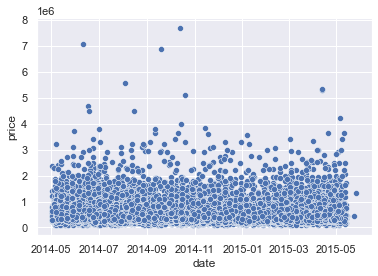

In [17]:
sns.scatterplot(x='date', y='price', data=df);

Next, I'll create a column for the month and another for the year. Each of these will be grouped by their respective distinct values and plotted.

In [18]:
df['month'] = df.date.dt.month
df_month = df.groupby('month').median()
df_month

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
month,,,,,,,,,,,,,,,,,,
1,438500.0,3.0,2.25,1890.0,7800.0,1.0,0.0,0.0,3.0,7.0,1570.0,1974.0,0.0,98065.0,47.55950,-122.2310,1800.0,7700.0
2,426500.0,3.0,2.00,1830.0,7667.0,1.0,0.0,0.0,3.0,7.0,1489.0,1974.0,0.0,98059.0,47.56120,-122.2290,1800.0,7638.0
3,450000.0,3.0,2.25,1870.0,7560.0,1.0,0.0,0.0,3.0,7.0,1540.0,1973.0,0.0,98065.0,47.56480,-122.2260,1820.0,7647.0
4,477000.0,3.0,2.25,1900.0,7500.0,1.5,0.0,0.0,3.0,7.0,1540.0,1976.0,0.0,98072.0,47.56860,-122.2290,1840.0,7560.0
5,462000.0,3.0,2.25,1930.0,7498.0,1.0,0.0,0.0,3.0,7.0,1540.0,1974.0,0.0,98072.0,47.57870,-122.2365,1840.0,7551.5
6,465000.0,3.0,2.25,1980.0,7700.0,1.5,0.0,0.0,3.0,8.0,1600.0,1975.0,0.0,98072.0,47.57605,-122.2290,1890.0,7720.0
7,465000.0,3.0,2.25,1950.0,7695.0,1.5,0.0,0.0,3.0,8.0,1610.0,1977.0,0.0,98059.0,47.57400,-122.2150,1870.0,7650.0
8,442200.0,3.0,2.25,1940.0,7810.0,1.0,0.0,0.0,3.0,7.0,1590.0,1976.0,0.0,98059.0,47.57720,-122.2220,1860.0,7755.0
9,450000.0,3.0,2.25,1920.0,7620.0,1.5,0.0,0.0,3.0,7.0,1580.0,1974.0,0.0,98065.0,47.57400,-122.2350,1830.0,7503.0


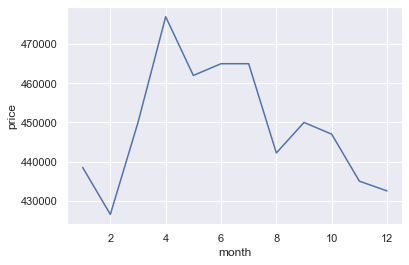

In [19]:
sns.lineplot(x='month', y='price', data=df_month);

In [20]:
df['year'] = df.date.dt.year
df_year = df.groupby('year').median()
df_year

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
year,,,,,,,,,,,,,,,,,,,
2014,450000.0,3.0,2.25,1930.0,7633.5,1.5,0.0,0.0,3.0,7.0,1580.0,1975.0,0.0,98065.0,47.57645,-122.231,1850.0,7620.0,8.0
2015,451000.0,3.0,2.25,1880.0,7576.0,1.0,0.0,0.0,3.0,7.0,1540.0,1974.0,0.0,98065.0,47.56370,-122.229,1820.0,7620.0,3.0


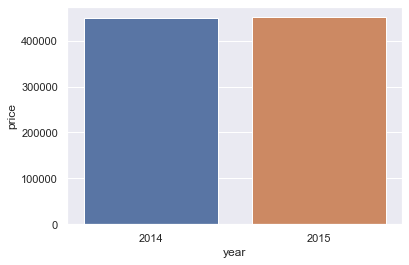

In [21]:
sns.barplot(x='year', y='price', data=df_year.reset_index());

As expected, there isn't much of a trend for the individual dates given the relatively short time horizon. Likewise, there's not much of a different between the values in 2014 and those in 2015. However, there is a clear trend when grouping the data by month with late spring to mid summer seeing the highest median prices. As a result of these findings, the `month` column will be kept in place of the `date` column going forward.

In [22]:
df.drop(columns=['date', 'year'], inplace=True)
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')

### 3. Convert the `sqft_basement` column to an integer and handle placeholder values
First, I need to handle the placeholder value of `?` discovered while analyzing the value counts. These placeholder values represent about 2% of the data in the column. Since the majority of houses in this dataset do not have a basement at all and I want to keep the contiuous nature of the data in this column, I will simply replace each of the placeholder values with `0`.

In [23]:
df.sqft_basement = df.sqft_basement.replace('?', 0)
df.sqft_basement.value_counts(normalize=True).head()

0.0      0.593879
0        0.021021
600.0    0.010048
500.0    0.009677
700.0    0.009631
Name: sqft_basement, dtype: float64

With the placeholders values out of the way, I can now convert the rest of the values to integers to align with the other columns that deal with square footage information. Due to the presence of `0.0`, which cannot be directly converted to an `int`, I must first convert the values to a `float` and then an `int`. 

In [24]:
df.sqft_basement = df.sqft_basement.apply(lambda x: int(float(x)))
df.sqft_basement.dtype

dtype('int64')

### 4. Drop the `yr_renovated` column
This column has the most amount of data missing. Of the data that isn't missing, approximately 95% has a placeholder value of `0.0` which likely indicates the house either hasn't been renovated or the renovation year is unknown. An argument could be made for converting the column to indicate whether a renovation has been made at all regardless of the year. However, given the subjective and arbitrary nature of renovations that cannot be captured quantitatively, the usefulness of that information is debateable at best. Factoring in all of this information, I will simply drop the column from the dataframe.

In [25]:
df.drop(columns=['yr_renovated'], inplace=True)
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'month'],
      dtype='object')

### 5. Handle missing values in `waterfront` and `view`
Starting with `waterfront`, I'll take a look at if the median price for houses with a waterfront is materially different than those without.

In [26]:
df.waterfront.value_counts(normalize=True)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64

In [27]:
df_waterfront = df.groupby('waterfront').median().reset_index()
df_waterfront

,waterfront,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,month
0,0.0,450000.0,3.0,2.25,1910.0,7589.0,1.5,0.0,3.0,7.0,1560.0,0.0,1975.0,98065.0,47.57220,-122.2300,1840.0,7600.0,6.0
1,1.0,1510000.0,3.0,2.50,2900.0,17730.5,2.0,4.0,3.0,9.0,2200.0,535.0,1959.5,98075.0,47.54815,-122.2735,2695.0,16260.5,7.0


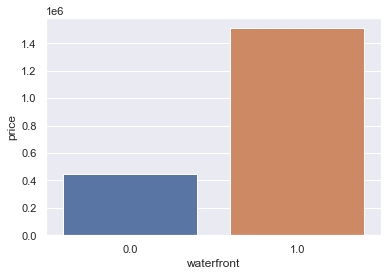

In [28]:
sns.barplot(x='waterfront', y='price', data=df_waterfront);

Houses with a waterfront have a much higher median value than those without. There are a few different ways to approach handling the missing values in this instance:
- Drop the rows entirely
- Impute the missing values based on the distribution of available values
- Set all missing values equal to the same value

With more than 99% of houses in the dataset not being a waterfront property, I will be setting all of the missing values to `0.0`. Dropping the rows entirely would throw away too much useful information and imputing the values would be better suited for a non-binary variable.

In [29]:
df.waterfront.isna().sum()

2376

In [30]:
df.waterfront.replace(np.nan, 0.0, inplace=True)
df.waterfront.isna().sum()

0

I'll take a similar approach with handling the missing values in the `view` column.

In [31]:
df.view.value_counts(normalize=True)

0.0    0.901923
2.0    0.044441
3.0    0.023591
1.0    0.015325
4.0    0.014721
Name: view, dtype: float64

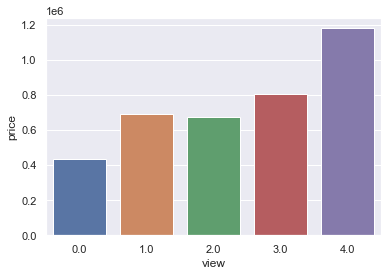

In [32]:
df_view = df.groupby('view').median().reset_index()
sns.barplot(x='view', y='price', data=df_view);

There's a clear trend where higher view grades are associated with higher median prices. The same options for dealing with the missing values in the `waterfront` column exist for the `view` column as well. In this instance, however, I _will_ impute the values since the variable is non-binary and somewhat subjective. Whereas setting a non-waterfront property to a value of having a waterfront is definitively incorrect, there is more leeway with the view categories. 

In [33]:
df.view.isna().sum()

63

In [34]:
values = df.view.value_counts().reset_index()['index'].values
probs = df.view.value_counts(normalize=True).values
df.view.replace(np.nan, np.random.choice(a=values, p=probs), inplace=True)
df.view.isna().sum()

0

Taking a look at all columns for any remaining missing values:

In [35]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
month            0
dtype: int64

### 6. Handle multicollinearity between highly correlated columns
The first step in handling multicollinearity is determing which columns have the highest absolute correlation with one another.

In [36]:
df_corr = df.corr().abs().stack().reset_index()
df_corr.head()

,level_0,level_1,0
0,price,price,1.000000
1,price,bedrooms,0.308787
2,price,bathrooms,0.525906
3,price,sqft_living,0.701917
4,price,sqft_lot,0.089876


In [37]:
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index('pairs', inplace=True)
df_corr.head()

,level_0,level_1,0
pairs,,,
"(price, price)",price,price,1.000000
"(price, bedrooms)",price,bedrooms,0.308787
"(price, bathrooms)",price,bathrooms,0.525906
"(price, sqft_living)",price,sqft_living,0.701917
"(price, sqft_lot)",price,sqft_lot,0.089876


In [38]:
df_corr.drop(columns=['level_0', 'level_1'], inplace=True)
df_corr.columns = ['cc']
df_corr.sort_values('cc', ascending=False, inplace=True)
df_corr.drop_duplicates(inplace=True)
df_corr.head()

,cc
pairs,
"(price, price)",1.000000
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(sqft_above, grade)",0.756073


In [39]:
df_corr[(df_corr.cc > 0.75) & (df_corr.cc < 1.00)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


The `sqft_living` column appears in four of the top five pairs of columns with the highest absolute correlations. As a result, this column will be dropped to help reduce multicollinearity.

In [40]:
df.drop(columns=['sqft_living'], inplace=True)
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')

## Modeling
---

### Baseline Model

In [41]:
def fit_model(df, target='price'):
    '''
    Description:
    ------------
    Takes a dataframe and returns a fitted OLS model with price as the dependent variable.
    
    Parameters:
    ------------
    df : pandas.DataFrame
        This dataframe should include all of the predictors and the target column.
    
    target: str
        The name of the column being predicted (dependent variable). The default is
        'price'. Useful for transformations where the name is changed for clarity 
        (e.g. 'price' --> 'price_log' for a log transformation).
    
    Example:
    ------------
    >>> fit_model(df)
    
    <statsmodels.regression.linear_model.RegressionResultsWrapper>
    '''
    
    predictors = df.drop(columns=[target])
    predictors = sm.add_constant(predictors)
    model = sm.OLS(df[target], predictors).fit()
    return model

model = fit_model(df)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2959.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:43:45   Log-Likelihood:            -2.9440e+05
No. Observations:               21597   AIC:                         5.888e+05
Df Residuals:                   21579   BIC:                         5.890e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.343e+06   2.93e+06      2.510      0.012    1.61e+06    1.31e+07
bedrooms      -3.561e+04   1896.107    -18.781      0.000   -3.93e+04   -3.19e+04
bathrooms      4.593e+04   3220.796     14.262      0.000    3.96e+04    5.22e+04
sqft_lot          0.1219      0.048      2.542      0.011       0.028       0.216
floors         6790.4318   3589.068      1.892      0.059    -244.407    1.38e+04
waterfront     6.234e+05   1.81e+04     34.387      0.000    5.88e+05    6.59e+05
view           5.383e+04   2121.194     25.379      0.000    4.97e+04     5.8e+04
condition      2.545e+04   2318.920     10.974      0.000    2.09e+04       3e+04
grade          9.801e+04   2157.106     45.437      0.000    9.38e+04    1.02e+05
sqft_above      178.8924      3.659     48.886      0.000     171.720     186.065
sqft_basement   146.9815      4.356     33.741      0.000     138.443     155.520
yr_built      -2776.1082     68.907    -40.288      0.000   -2911.170   -2641.046
zipcode        -587.2023     32.996    -17.796      0.000    -651.877    -522.527
lat            5.996e+05   1.07e+04     55.852      0.000    5.79e+05    6.21e+05
long           -2.17e+05   1.32e+04    -16.498      0.000   -2.43e+05   -1.91e+05
sqft_living15    21.1073      3.447      6.123      0.000      14.350      27.864
sqft_lot15       -0.3712      0.073     -5.060      0.000      -0.515      -0.227
month         -3075.1729    440.253     -6.985      0.000   -3938.101   -2212.245
==============================================================================
Omnibus:                    18407.855   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1866250.699
Skew:                           3.579   Prob(JB):                         0.00
Kurtosis:                      47.974   Cond. No.                     2.15e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observations:**
- `bedrooms` has a negativate coefficient (surprisingly)
- `floors` is not significant at the alpha = 0.05 level
- `yr_built` has a negative coefficient (suprisingly)
- R-squared value for baseline model is 0.700 - pretty good

I also want to keep track of the RMSE for each model, so I'll create a reusable function to do just that:

In [42]:
def print_rmse(df, target='price', decimals=2):
    '''
    Description:
    ------------
    Takes a dataframe, splits it into train/test data, fits it to a linear regression model,
    then calculates and prints the RMSE for both the train and test portions rounded to two
    decimal places.
    
    Parameters:
    ------------
    df : pandas.DataFrame
        This dataframe should include all of the predictors and the target column.
    
    target: str
        The name of the column being predicted (dependent variable). The default is
        'price'. Useful for transformations where the name is changed for clarity 
        (e.g. 'price' --> 'price_log' for a log transformation).
    
    decimals: int
        The number of decimals to round the output to.
    
    Example:
    ------------
    >>> print_rmse(df)
    
        Train RMSE: 100,000.00
        Test RMSE:  101,250.00
    '''
    
    x = df.drop(columns=[target])
    y = df[target]
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=85)
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)
    
    y_pred_train = linreg.predict(x_train)
    y_pred_test = linreg.predict(x_test)
    
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    
    print('Train RMSE:', round(rmse_train, decimals))
    print('Test  RMSE:', round(rmse_test, decimals))

In [43]:
print_rmse(df)

Train RMSE: 201973.07
Test  RMSE: 199329.26


These are fairly large values for the RMSE but both the train and test splits are relatively in line with one another which indicates an appropriately fitted model.

Finally, I'll plot the residuals in a Q-Q plot to check for normality.

In [44]:
def get_qqplot(model):
    '''
    Description:
    ------------
    Takes an OLS model and returns a Q-Q plot of the model residuals.
    
    Parameters:
    ------------
    model : a fitted statsmodels.api.OLS() model
    
    Example:
    ------------
    >>> get_qqplot(model)
    
    <matplotlib.figure.Figure>
    '''
    
    return sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

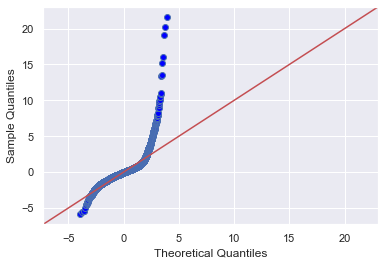

In [45]:
get_qqplot(model);

The residuals of the baseline model are not normally distributed which violates a core assumption of linear regression. I will attempt to correct this in subsequent models.

### Removing Outliers

In [46]:
df.describe()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,month
count,2.159700e+04,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,1.509941e+04,1.494096,0.006760,0.233181,3.409825,7.657915,1788.596842,285.716581,1970.999676,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,6.573969
std,3.673681e+05,0.926299,0.768984,4.141264e+04,0.539683,0.081944,0.764673,0.650546,1.173200,827.759761,439.819830,29.375234,53.513072,0.138552,0.140724,685.230472,27274.441950,3.115061
min,7.800000e+04,1.000000,0.500000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000
25%,3.220000e+05,3.000000,1.750000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,4.000000
50%,4.500000e+05,3.000000,2.250000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,6.000000
75%,6.450000e+05,4.000000,2.500000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,9.000000
max,7.700000e+06,33.000000,8.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,12.000000


The maximum amount of bedrooms being 33 immediately jumps out to me as warranting further investigation.

In [47]:
df[df.bedrooms == 33]

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,month
15856,640000.0,33,1.75,6000,1.0,0.0,0.0,5,7,1040,580,1947,98103,47.6878,-122.331,1330,4700,6


The price, bathrooms, and square footage of this property do not meet the expectations of a 33 bedroom house. This entry was likely a typo that should have shown only 3 bedrooms. I'll plot bedrooms against some of the other columns as a quick check for anything else that looks off.

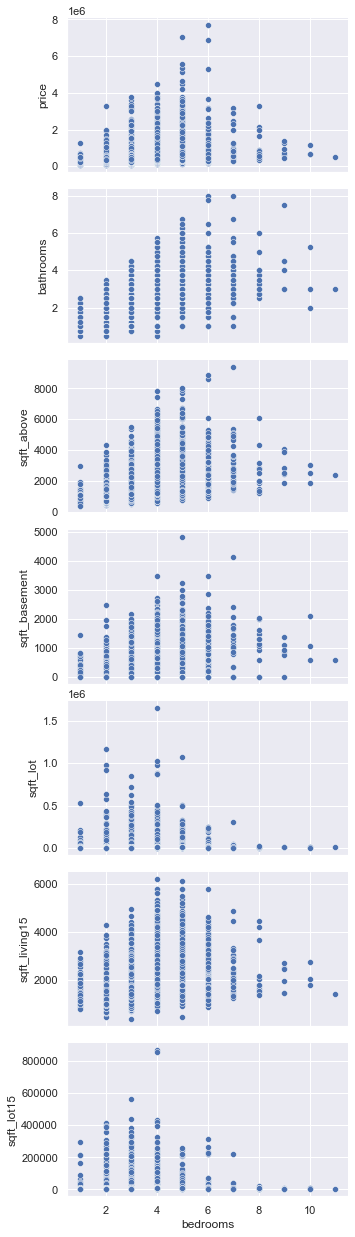

In [48]:
sns.pairplot(df[df.bedrooms < 33], 
             x_vars=['bedrooms'],
             y_vars=['price', 'bathrooms', 'sqft_above', 'sqft_basement', 'sqft_lot', 
                     'sqft_living15', 'sqft_lot15'],
             diag_kind=None,
             aspect=2
            );

It appears that houses with more than 8 bedrooms have counterintuitive characteristics such as less bathrooms, less square footage, and a lower price. There could be a number of reasons for these discrepencies including:
- Incorrect data entry
- Nontraditional housing such as dorms / communal living
- Older housing

In [49]:
print(f'Number of houses with more than 8 bedrooms: {len(df[df.bedrooms > 8])}')

Number of houses with more than 8 bedrooms: 11


With only 11 houses having more than 8 bedrooms, I'm comfortable with simply dropping those rows.

In [50]:
df_no_outliers = df[df.bedrooms <= 8]
df_no_outliers.bedrooms.describe()

count    21586.000000
mean         3.368989
std          0.894531
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          8.000000
Name: bedrooms, dtype: float64

Next, I also want to investigate the minimum number of bathrooms being only 0.5.

In [51]:
df_no_outliers[df_no_outliers.bathrooms == 0.5]

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,month
2259,273000.0,2,0.5,7750,1.0,0.0,0.0,4,6,590,590,1945,98155,47.7690,-122.316,1380,8976,10
10413,109000.0,2,0.5,6900,1.0,0.0,0.0,3,5,580,0,1941,98118,47.5135,-122.262,1570,5040,1
11662,255000.0,1,0.5,1642,1.0,0.0,0.0,3,6,500,380,1910,98126,47.5732,-122.372,1410,2992,8
12029,312500.0,4,0.5,5570,2.0,0.0,0.0,3,8,2300,0,1996,98092,47.3285,-122.168,1820,6371,12


Of the four results, the first three look like they could possibly be a dorm / communal living type of property gvien their `sqft_above` values. The fourth result of a property with 4 bedrooms and 2,300 sqft is definitely an outlier and should have at least one full bath. This will be dropped but I'll keep the first three.

In [52]:
df_no_outliers.drop(index=12029, inplace=True)

# Checking to make sure it was correctly dropped
df_no_outliers[df_no_outliers.bathrooms == 0.5]

E:\Programs\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,month
2259,273000.0,2,0.5,7750,1.0,0.0,0.0,4,6,590,590,1945,98155,47.7690,-122.316,1380,8976,10
10413,109000.0,2,0.5,6900,1.0,0.0,0.0,3,5,580,0,1941,98118,47.5135,-122.262,1570,5040,1
11662,255000.0,1,0.5,1642,1.0,0.0,0.0,3,6,500,380,1910,98126,47.5732,-122.372,1410,2992,8


The final adjustment for this second model is to remove the `floors` column which is not significant.

In [53]:
pd.set_option('mode.chained_assignment', None)  # Supressing the 'SettingWithCopyWarning'
df_no_outliers.drop(columns=['floors'], inplace=True)
df_no_outliers.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')

In [54]:
model_2 = fit_model(df_no_outliers)
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     3149.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:43:47   Log-Likelihood:            -2.9422e+05
No. Observations:               21585   AIC:                         5.885e+05
Df Residuals:                   21568   BIC:                         5.886e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            6.7e+06   2.88e+06      2.325      0.020    1.05e+06    1.23e+07
bedrooms      -3.931e+04   1993.709    -19.717      0.000   -4.32e+04   -3.54e+04
bathrooms      4.887e+04   3115.790     15.684      0.000    4.28e+04     5.5e+04
sqft_lot          0.1174      0.048      2.451      0.014       0.024       0.211
waterfront      6.22e+05   1.81e+04     34.334      0.000    5.87e+05    6.58e+05
view           5.367e+04   2119.850     25.316      0.000    4.95e+04    5.78e+04
condition      2.516e+04   2312.953     10.880      0.000    2.06e+04    2.97e+04
grade          9.776e+04   2150.289     45.464      0.000    9.35e+04    1.02e+05
sqft_above      182.1754      3.623     50.288      0.000     175.075     189.276
sqft_basement   146.4884      4.169     35.141      0.000     138.318     154.659
yr_built      -2756.7850     67.368    -40.921      0.000   -2888.831   -2624.739
zipcode        -583.8860     32.840    -17.780      0.000    -648.255    -519.517
lat            6.001e+05   1.07e+04     56.103      0.000    5.79e+05    6.21e+05
long          -2.192e+05   1.31e+04    -16.737      0.000   -2.45e+05   -1.94e+05
sqft_living15    20.2822      3.423      5.926      0.000      13.574      26.991
sqft_lot15       -0.3816      0.073     -5.208      0.000      -0.525      -0.238
month         -3072.4854    440.011     -6.983      0.000   -3934.940   -2210.031
==============================================================================
Omnibus:                    18271.635   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1821637.635
Skew:                           3.544   Prob(JB):                         0.00
Kurtosis:                      47.443   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
print_rmse(df_no_outliers)

Train RMSE: 206118.02
Test  RMSE: 185727.5


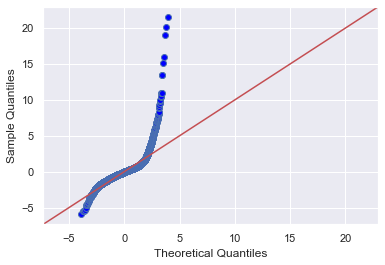

In [56]:
get_qqplot(model_2);

**Observations:**
- No change in the R-squared value - still at 0.700
- Slight decrease in the test RMSE but slight *increase* in the train RMSE
- The Q-Q plot still shows non-normality in the residuals

### Categorical Variables
The first two versions of the model were completing neglecting the fact that certain columns were being treated as continuous data when they are in fact categorical. To adjust for this going forward, I'll convert the categorical columns into multiple columns filled with dummy variables. 

In [57]:
df_categoricals = df_no_outliers.copy()
df_categoricals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21585 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21585 non-null  float64
 1   bedrooms       21585 non-null  int64  
 2   bathrooms      21585 non-null  float64
 3   sqft_lot       21585 non-null  int64  
 4   waterfront     21585 non-null  float64
 5   view           21585 non-null  float64
 6   condition      21585 non-null  int64  
 7   grade          21585 non-null  int64  
 8   sqft_above     21585 non-null  int64  
 9   sqft_basement  21585 non-null  int64  
 10  yr_built       21585 non-null  int64  
 11  zipcode        21585 non-null  int64  
 12  lat            21585 non-null  float64
 13  long           21585 non-null  float64
 14  sqft_living15  21585 non-null  int64  
 15  sqft_lot15     21585 non-null  int64  
 16  month          21585 non-null  int64  
dtypes: float64(6), int64(11)
memory usage: 3.0 MB


In [58]:
categoricals = ['waterfront', 'view', 'condition', 'grade', 'zipcode', 'month']

# Generating a temporary dataframe for each of the categorical columns
temp_dfs = [df_categoricals]
for cat in categoricals:
    dummy = pd.get_dummies(df_categoricals[cat], prefix=cat, drop_first=True)
    temp_dfs.append(dummy)

# Combining them all together
df_categoricals = pd.concat(temp_dfs, axis=1)

# Dropping the original columns now that the dummies exist
df_categoricals.drop(columns=categoricals, inplace=True)

In [59]:
df_categoricals.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21585 entries, 0 to 21596
Data columns (total 110 columns):
 #   Column          Dtype  
---  ------          -----  
 0   price           float64
 1   bedrooms        int64  
 2   bathrooms       float64
 3   sqft_lot        int64  
 4   sqft_above      int64  
 5   sqft_basement   int64  
 6   yr_built        int64  
 7   lat             float64
 8   long            float64
 9   sqft_living15   int64  
 10  sqft_lot15      int64  
 11  waterfront_1.0  uint8  
 12  view_1.0        uint8  
 13  view_2.0        uint8  
 14  view_3.0        uint8  
 15  view_4.0        uint8  
 16  condition_2     uint8  
 17  condition_3     uint8  
 18  condition_4     uint8  
 19  condition_5     uint8  
 20  grade_4         uint8  
 21  grade_5         uint8  
 22  grade_6         uint8  
 23  grade_7         uint8  
 24  grade_8         uint8  
 25  grade_9         uint8  
 26  grade_10        uint8  
 27  grade_11        uint8  
 28  grade_12       

With the dummy variables now in place, it's time to check the impact it had on model performance.

In [60]:
model_3 = fit_model(df_categoricals)
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     997.0
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:43:48   Log-Likelihood:            -2.8777e+05
No. Observations:               21585   AIC:                         5.758e+05
Df Residuals:                   21475   BIC:                         5.766e+05
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.287e+07   5.73e+06     -5.734      0.000   -4.41e+07   -2.16e+07
bedrooms       -1.334e+04   1540.987     -8.658      0.000   -1.64e+04   -1.03e+04
bathrooms       2.625e+04   2395.777     10.957      0.000    2.16e+04    3.09e+04
sqft_lot           0.2442      0.036      6.817      0.000       0.174       0.314
sqft_above       158.4193      2.848     55.616      0.000     152.836     164.002
sqft_basement    120.4862      3.165     38.072      0.000     114.283     126.689
yr_built        -682.3172     55.697    -12.251      0.000    -791.487    -573.147
lat             2.265e+05   5.91e+04      3.834      0.000    1.11e+05    3.42e+05
long           -1.917e+05   4.25e+04     -4.512      0.000   -2.75e+05   -1.08e+05
sqft_living15     16.9243      2.705      6.258      0.000      11.623      22.225
sqft_lot15        -0.1083      0.056     -1.921      0.055      -0.219       0.002
waterfront_1.0  5.973e+05   1.54e+04     38.696      0.000    5.67e+05    6.28e+05
view_1.0        8.669e+04   8523.735     10.171      0.000       7e+04    1.03e+05
view_2.0        6.936e+04   5208.499     13.316      0.000    5.91e+04    7.96e+04
view_3.0        1.536e+05   7113.850     21.594      0.000     1.4e+05    1.68e+05
view_4.0        2.974e+05   1.07e+04     27.711      0.000    2.76e+05    3.18e+05
condition_2     9.127e+04   3.02e+04      3.018      0.003     3.2e+04    1.51e+05
condition_3     1.035e+05   2.81e+04      3.678      0.000    4.83e+04    1.59e+05
condition_4     1.274e+05   2.82e+04      4.523      0.000    7.22e+04    1.83e+05
condition_5     1.707e+05   2.83e+04      6.026      0.000    1.15e+05    2.26e+05
grade_4        -1.029e+05   1.53e+05     -0.674      0.501   -4.02e+05    1.97e+05
grade_5        -1.371e+05    1.5e+05     -0.912      0.362   -4.32e+05    1.58e+05
grade_6        -1.354e+05    1.5e+05     -0.902      0.367    -4.3e+05    1.59e+05
grade_7        -1.291e+05    1.5e+05     -0.860      0.390   -4.23e+05    1.65e+05
grade_8        -1.083e+05    1.5e+05     -0.721      0.471   -4.02e+05    1.86e+05
grade_9        -3.377e+04    1.5e+05     -0.225      0.822   -3.28e+05    2.61e+05
grade_10        8.805e+04    1.5e+05      0.586      0.558   -2.07e+05    3.83e+05
grade_11        2.857e+05    1.5e+05      1.898      0.058   -9318.928    5.81e+05
grade_12        6.956e+05   1.51e+05      4.598      0.000    3.99e+05    9.92e+05
grade_13        1.809e+06   1.56e+05     11.567      0.000     1.5e+06    2.12e+06
zipcode_98002   1.534e+04   1.35e+04      1.137      0.255   -1.11e+04    4.18e+04
zipcode_98003  -1.246e+04   1.21e+04     -1.033      0.301   -3.61e+04    1.12e+04
zipcode_98004   7.102e+05   2.19e+04     32.403      0.000    6.67e+05    7.53e+05
zipcode_98005   2.605e+05   2.34e+04     11.123      0.000    2.15e+05    3.06e+05
zipcode_9800

In [61]:
print_rmse(df_categoricals)

Train RMSE: 150761.63
Test  RMSE: 147644.2


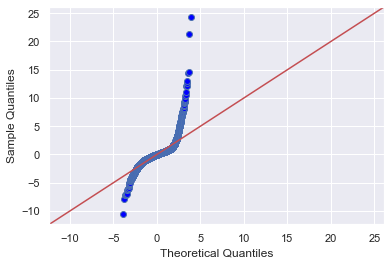

In [62]:
get_qqplot(model_3);

**Observations:**
- Large improvement in the R-squared value
- Many of the dummy variable columns are showing non-significant p-values
- Also good improvement in the RMSE values, model remains decently fit
- The Q-Q plot is still showing non-normality in the residuals

### Transformations

#### Log Transformation

In [63]:
df_log = df_categoricals.copy()
continuous = df_log.columns[:11]
continuous

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

Checking the distributions of each of the continuous variables:

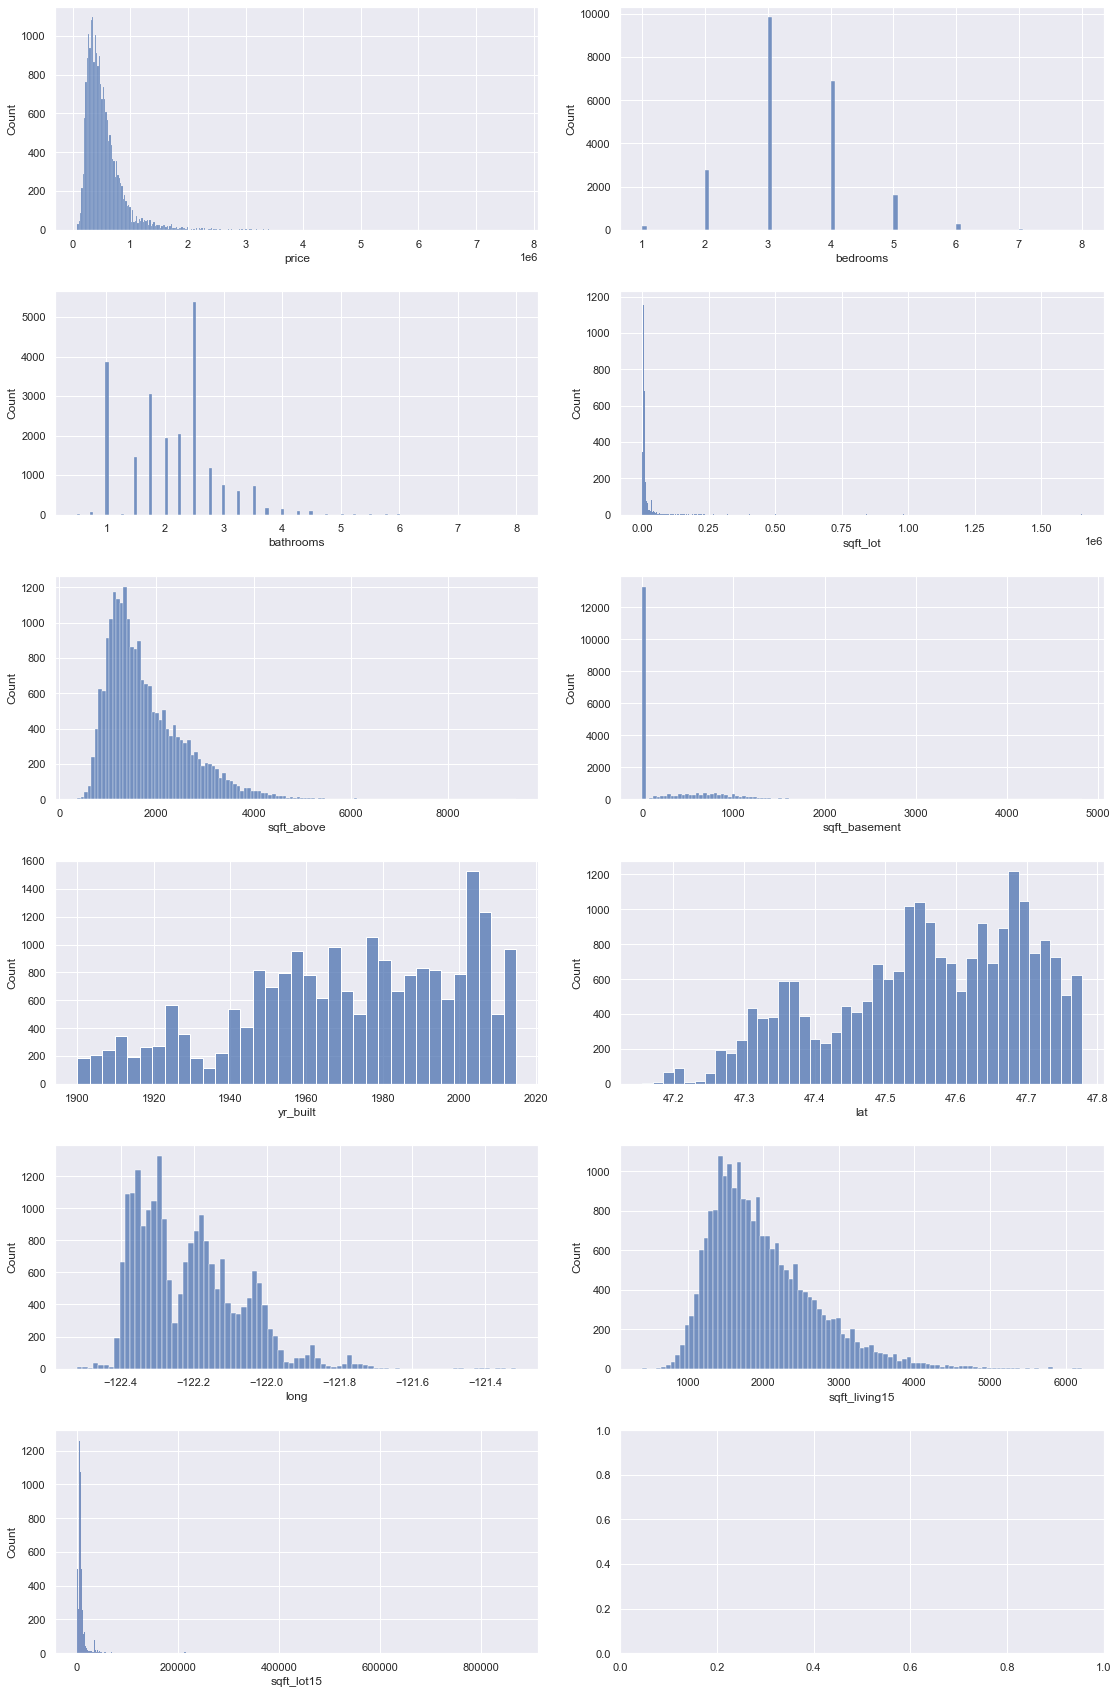

In [64]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16, 24))
axes = axes.reshape(-1)

for i, col in enumerate(continuous):
    sns.histplot(data=df_log[col], ax=axes[i])
    
fig.tight_layout(pad=2.0)

All of the continous variables exhibit skewness to some degree. Applying a log transformation to each of those columns may help and increase the model's R-squared value. However, `sqft_basement` contains many zero values and `long` contains all negative values which are invalid for log transformations. These will remain as they currently are.

In [65]:
continuous = continuous.drop(['sqft_basement', 'long'])

for col in continuous:
    df_log[col] = df_log[col].map(lambda x: np.log(x))
    df_log.rename(columns={col: col+'_log'}, inplace=True)

In [66]:
df_log.head()

,price_log,bedrooms_log,bathrooms_log,sqft_lot_log,sqft_above_log,sqft_basement,yr_built_log,lat_log,long,sqft_living15_log,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,12.309982,1.098612,0.000000,8.639411,7.073270,0,7.578145,3.860965,-122.257,7.200425,...,0,0,0,0,0,0,0,1,0,0
1,13.195614,1.098612,0.810930,8.887653,7.682482,400,7.576097,3.865372,-122.319,7.432484,...,0,0,0,0,0,0,0,0,0,1
2,12.100712,0.693147,0.000000,9.210340,6.646391,0,7.566828,3.865726,-122.233,7.908387,...,0,0,0,0,0,0,0,0,0,0
3,13.311329,1.386294,1.098612,8.517193,6.956545,910,7.583248,3.861168,-122.393,7.215240,...,0,0,0,0,0,0,0,0,0,1
4,13.142166,1.098612,0.693147,8.997147,7.426549,0,7.594381,3.863186,-122.045,7.495542,...,0,0,0,0,0,0,0,0,0,0


Checking the distributions again:

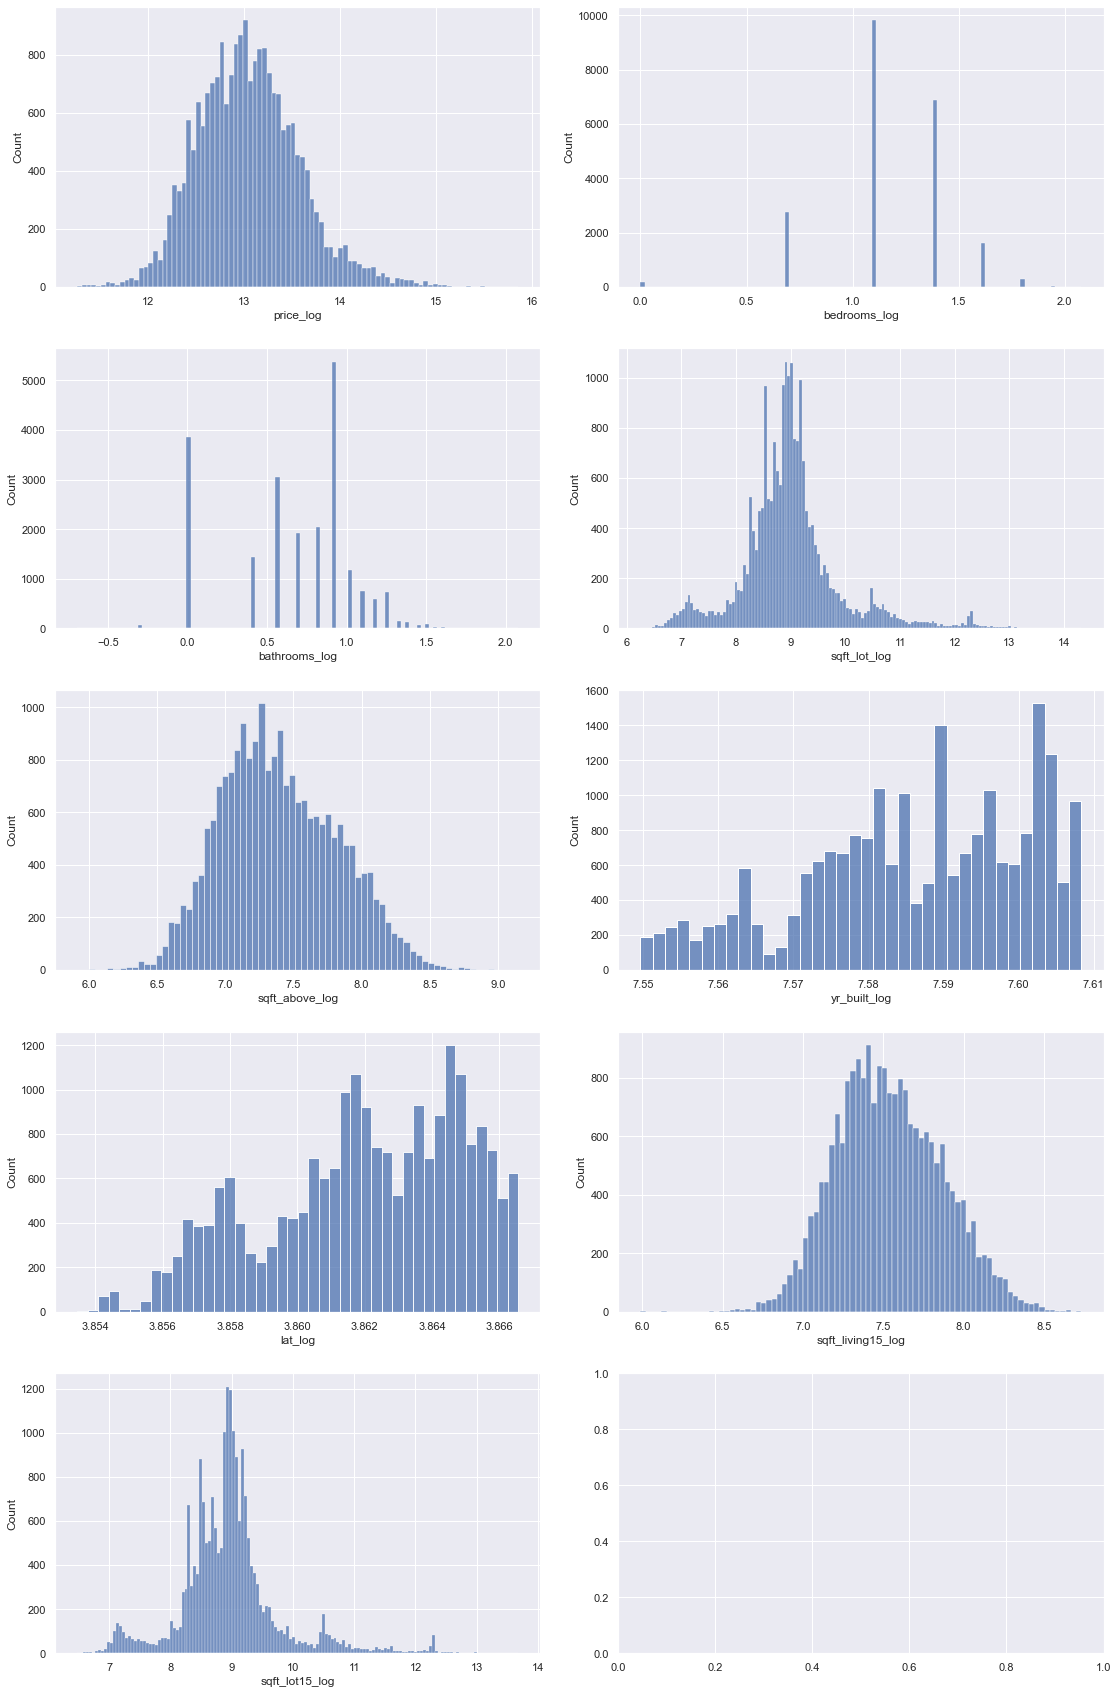

In [67]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 24))
axes = axes.reshape(-1)

for i, col in enumerate(continuous):
    sns.histplot(data=df_log[col+'_log'], ax=axes[i])
    
fig.tight_layout(pad=2.0)

It's not perfect, but it's definitely better than before. Time to see how it impacted the model.

In [68]:
model_4 = fit_model(df_log, target='price_log')
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1517.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:44:07   Log-Likelihood:                 6565.0
No. Observations:               21585   AIC:                        -1.291e+04
Df Residuals:                   21475   BIC:                        -1.203e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -132.7702     14.085     -9.426      0.000    -160.378    -105.162
bedrooms_log         -0.0266      0.006     -4.441      0.000      -0.038      -0.015
bathrooms_log         0.0870      0.006     15.626      0.000       0.076       0.098
sqft_lot_log          0.0760      0.004     21.206      0.000       0.069       0.083
sqft_above_log        0.3683      0.006     57.268      0.000       0.356       0.381
sqft_basement         0.0001   3.76e-06     32.718      0.000       0.000       0.000
yr_built_log         -0.9818      0.137     -7.155      0.000      -1.251      -0.713
lat_log              25.1273      3.359      7.480      0.000      18.543      31.711
long                 -0.4195      0.051     -8.193      0.000      -0.520      -0.319
sqft_living15_log     0.1636      0.007     24.858      0.000       0.151       0.176
sqft_lot15_log       -0.0179      0.004     -4.501      0.000      -0.026      -0.010
waterfront_1.0        0.4473      0.018     24.230      0.000       0.411       0.483
view_1.0              0.1078      0.010     10.566      0.000       0.088       0.128
view_2.0              0.0979      0.006     15.713      0.000       0.086       0.110
view_3.0              0.1658      0.008     19.526      0.000       0.149       0.182
view_4.0              0.2715      0.013     21.153      0.000       0.246       0.297
condition_2           0.1565      0.036      4.324      0.000       0.086       0.227
condition_3           0.2988      0.034      8.865      0.000       0.233       0.365
condition_4           0.3369      0.034      9.990      0.000       0.271       0.403
condition_5           0.4045      0.034     11.922      0.000       0.338       0.471
grade_4              -0.5180      0.183     -2.833      0.005      -0.876      -0.160
grade_5              -0.5270      0.180     -2.929      0.003      -0.880      -0.174
grade_6              -0.4466      0.180     -2.487      0.013      -0.799      -0.095
grade_7              -0.3674      0.180     -2.046      0.041      -0.720      -0.015
grade_8              -0.2878      0.180     -1.602      0.109      -0.640       0.064
grade_9              -0.1670      0.180     -0.929      0.353      -0.519       0.185
grade_10             -0.0758      0.180     -0.421      0.674      -0.428       0.277
grade_11              0.0347      0.180      0.192      0.847      -0.318       0.388
grade_12              0.1590      0.181      0.879      0.380      -0.196       0.514
grade_13              0.3917      0.187      2.095      0.036       0.025       0.758
zipcode_98002         0.0212      0.016      1.312      0.190      -0.010       0.053
zipcode_98003         0.0004      0.014      0.031      0.975      -0.028       0.029
zipcode_98004         0.9891      0.026     37.670      0.000       0.938

In [69]:
print_rmse(df_log, target='price_log', decimals=4)

Train RMSE: 0.178
Test  RMSE: 0.1809


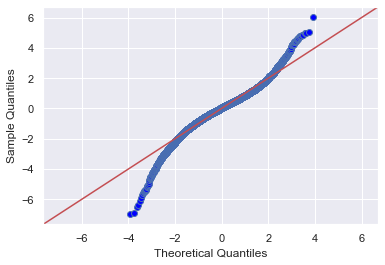

In [70]:
get_qqplot(model_4);

**Observations:**
- Highest R-squared value yet! 
- The RMSE is now in log units but is still well fit
- Large improvement in the normality of the residuals but still some issues at the tails
- There's a mismatch in the scale between different coefficients since only some variables have been log transformed while others haven't

#### Scaling
In an attempt to deal with the mismatch of scale between certain variables as noted above, I'll apply the `RobustScaler` from `sklearn.preprocessing`. This scaler removes the median and scales the data according to the IQR. Furthermore, this scaler in particular is less sensitive to outliers than other popular scalers such as the `MinMaxScaler` which is ideal for this particular dataset. 

In [71]:
df_scaled = df_log.copy()
columns = [col+'_scaled' for col in df_scaled.columns]

# Apply the scaler
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df_scaled)

# Converting back to a dataframe and previewing
df_scaled = pd.DataFrame(df_scaled, columns=columns)
df_scaled.head()

,price_log_scaled,bedrooms_log_scaled,bathrooms_log_scaled,sqft_lot_log_scaled,sqft_above_log_scaled,sqft_basement_scaled,yr_built_log_scaled,lat_log_scaled,long_scaled,sqft_living15_log_scaled,...,month_3_scaled,month_4_scaled,month_5_scaled,month_6_scaled,month_7_scaled,month_8_scaled,month_9_scaled,month_10_scaled,month_11_scaled,month_12_scaled
0,-1.017737,0.000000,-2.273583,-0.397967,-0.450975,0.000000,-0.436758,-0.292956,-0.133005,-0.689511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.257106,0.000000,0.000000,-0.067692,0.533151,0.727273,-0.524646,0.719685,-0.438424,-0.184909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.318976,-1.409421,-2.273583,0.361630,-1.140559,0.000000,-0.922383,0.801062,-0.014778,0.849921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.423675,1.000000,0.806567,-0.560572,-0.639532,1.654545,-0.217823,-0.246523,-0.802956,-0.657296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.180169,0.000000,-0.330225,0.077985,0.119715,0.000000,0.259937,0.217301,0.911330,-0.047792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
model_5 = fit_model(df_scaled, target='price_log_scaled')
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       price_log_scaled   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1517.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:44:08   Log-Likelihood:                -1297.9
No. Observations:               21585   AIC:                             2816.
Df Residuals:                   21475   BIC:                             3694.
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.1748      0.261     -0.671      0.502      -0.685       0.336
bedrooms_log_scaled         -0.0110      0.002     -4.441      0.000      -0.016      -0.006
bathrooms_log_scaled         0.0447      0.003     15.626      0.000       0.039       0.050
sqft_lot_log_scaled          0.0823      0.004     21.206      0.000       0.075       0.090
sqft_above_log_scaled        0.3282      0.006     57.268      0.000       0.317       0.339
sqft_basement_scaled         0.0974      0.003     32.718      0.000       0.092       0.103
yr_built_log_scaled         -0.0329      0.005     -7.155      0.000      -0.042      -0.024
lat_log_scaled               0.1574      0.021      7.480      0.000       0.116       0.199
long_scaled                 -0.1226      0.015     -8.193      0.000      -0.152      -0.093
sqft_living15_log_scaled     0.1083      0.004     24.858      0.000       0.100       0.117
sqft_lot15_log_scaled       -0.0176      0.004     -4.501      0.000      -0.025      -0.010
waterfront_1.0_scaled        0.6439      0.027     24.230      0.000       0.592       0.696
view_1.0_scaled              0.1551      0.015     10.566      0.000       0.126       0.184
view_2.0_scaled              0.1409      0.009     15.713      0.000       0.123       0.158
view_3.0_scaled              0.2386      0.012     19.526      0.000       0.215       0.263
view_4.0_scaled              0.3909      0.018     21.153      0.000       0.355       0.427
condition_2_scaled           0.2253      0.052      4.324      0.000       0.123       0.327
condition_3_scaled           0.4301      0.049      8.865      0.000       0.335       0.525
condition_4_scaled           0.4849      0.049      9.990      0.000       0.390       0.580
condition_5_scaled           0.5823      0.049     11.922      0.000       0.487       0.678
grade_4_scaled              -0.7456      0.263     -2.833      0.005      -1.261      -0.230
grade_5_scaled              -0.7586      0.259     -2.929      0.003      -1.266      -0.251
grade_6_scaled              -0.6429      0.259     -2.487      0.013      -1.150      -0.136
grade_7_scaled              -0.5289      0.259     -2.046      0.041      -1.036      -0.022
grade_8_scaled              -0.4143      0.259     -1.602      0.109      -0.921       0.093
grade_9_scaled              -0.2404      0.259     -0.929      0.353      -0.748       0.267
grade_10_scaled             -0.1091      0.259     -0.421      0.674      -0.617       0.398
grade_11_scaled              0.0499      0.259      0.192      0.847      -0.458       0.558
grade_12_scaled              0.2289      0.261      0.879      0.380      -0.282       0.740
grade_13_scaled              0.5638      0.269      2.095      0.036       0.036       1.091
zipcode_98002_

In [73]:
print_rmse(df_scaled, target='price_log_scaled', decimals=4)

Train RMSE: 0.2563
Test  RMSE: 0.2604


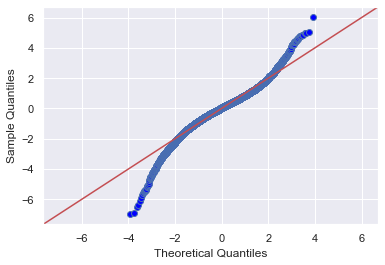

In [74]:
get_qqplot(model_5);

**Observations:**
- No change in the R-squared value from just the log transformed model
- Interpretability is much more challenging for this model
- While worth exploring, this model doesn't provide any additional benefit and will not be used as the final version

### Dropping Non-Significant Variables

In [75]:
nonsig = model_4.pvalues.where(model_4.pvalues > 0.05)
nonsig.dropna(inplace=True)
nonsig.index

Index(['grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12',
       'zipcode_98002', 'zipcode_98003', 'zipcode_98168', 'zipcode_98188',
       'zipcode_98198', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

In [76]:
df_drop_nonsig = df_log.copy()
df_drop_nonsig.drop(columns=nonsig.index, inplace=True)
df_drop_nonsig.columns

Index(['price_log', 'bedrooms_log', 'bathrooms_log', 'sqft_lot_log',
       'sqft_above_log', 'sqft_basement', 'yr_built_log', 'lat_log', 'long',
       'sqft_living15_log', 'sqft_lot15_log', 'waterfront_1.0', 'view_1.0',
       'view_2.0', 'view_3.0', 'view_4.0', 'condition_2', 'condition_3',
       'condition_4', 'condition_5', 'grade_4', 'grade_5', 'grade_6',
       'grade_7', 'grade_13', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipc

In [77]:
model_6 = fit_model(df_drop_nonsig, target='price_log')
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1653.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:44:08   Log-Likelihood:                 5659.9
No. Observations:               21585   AIC:                        -1.114e+04
Df Residuals:                   21493   BIC:                        -1.040e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -143.1816     10.431    -13.727      0.000    -163.626    -122.737
bedrooms_log         -0.0612      0.006     -9.908      0.000      -0.073      -0.049
bathrooms_log         0.0809      0.006     13.947      0.000       0.070       0.092
sqft_lot_log          0.0803      0.004     21.511      0.000       0.073       0.088
sqft_above_log        0.4668      0.006     74.708      0.000       0.455       0.479
sqft_basement         0.0001   3.88e-06     37.158      0.000       0.000       0.000
yr_built_log         -0.0835      0.141     -0.592      0.554      -0.360       0.193
lat_log              26.7525      2.405     11.125      0.000      22.039      31.466
long                 -0.3863      0.051     -7.623      0.000      -0.486      -0.287
sqft_living15_log     0.2022      0.007     29.850      0.000       0.189       0.216
sqft_lot15_log       -0.0108      0.004     -2.616      0.009      -0.019      -0.003
waterfront_1.0        0.4552      0.019     23.677      0.000       0.418       0.493
view_1.0              0.1088      0.011     10.254      0.000       0.088       0.130
view_2.0              0.1106      0.006     17.071      0.000       0.098       0.123
view_3.0              0.1910      0.009     21.656      0.000       0.174       0.208
view_4.0              0.3147      0.013     23.624      0.000       0.289       0.341
condition_2           0.1795      0.038      4.760      0.000       0.106       0.253
condition_3           0.3243      0.035      9.236      0.000       0.255       0.393
condition_4           0.3570      0.035     10.162      0.000       0.288       0.426
condition_5           0.4273      0.035     12.087      0.000       0.358       0.497
grade_4              -0.1564      0.037     -4.254      0.000      -0.228      -0.084
grade_5              -0.1821      0.013    -13.571      0.000      -0.208      -0.156
grade_6              -0.1207      0.006    -19.147      0.000      -0.133      -0.108
grade_7              -0.0781      0.004    -21.199      0.000      -0.085      -0.071
grade_13              0.4336      0.052      8.261      0.000       0.331       0.536
zipcode_98004         1.0178      0.018     55.892      0.000       0.982       1.054
zipcode_98005         0.6159      0.021     29.008      0.000       0.574       0.657
zipcode_98006         0.5843      0.016     35.767      0.000       0.552       0.616
zipcode_98007         0.5496      0.023     24.362      0.000       0.505       0.594
zipcode_98008         0.5483      0.020     26.922      0.000       0.508       0.588
zipcode_98010         0.3114      0.024     13.007      0.000       0.264       0.358
zipcode_98011         0.2125      0.025      8.445      0.000       0.163       0.262
zipcode_98014         0.2312      0.034      6.879      0.000       0.165

In [78]:
print_rmse(df_drop_nonsig, target='price_log', decimals=4)

Train RMSE: 0.1859
Test  RMSE: 0.1878


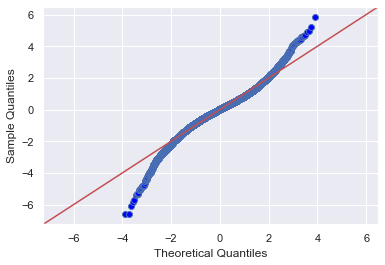

In [79]:
get_qqplot(model_6);

**Observations:**
- Small decrease in R-squared
- All but one variable (`yr_built`) are now significant at the alpha = 0.05 level
- RMSE increased slightly

### Model Comparisons

In [80]:
rsquareds = [model.rsquared, model_2.rsquared, model_3.rsquared,
             model_4.rsquared, model_5.rsquared, model_6.rsquared]

df_comparison = pd.DataFrame({'Model': [f'Model {i}' for i in range(1, 7)],
                              'R-squared': rsquareds})
df_comparison

,Model,R-squared
0,Model 1,0.699828
1,Model 2,0.700233
2,Model 3,0.835001
3,Model 4,0.885039
4,Model 5,0.885039
5,Model 6,0.874982


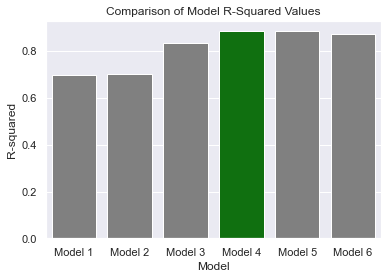

In [81]:
sns.barplot(data=df_comparison, 
            x='Model',
            y='R-squared', 
            palette=['green' if m == 'Model 4' else 'gray' for m in df_comparison.Model]
           )
plt.title('Comparison of Model R-Squared Values')
plt.savefig('images/r2_comp.png', dpi=150, facecolor='white');

## Conclusion
---
### Results
The fourth model, which removes outliers, includes dummy variables for categorical data, and log transforms continuous data, was the best performing model. This model explains approximately 88.5% of the variations in price for houses in the dataset. Some of the most impactful variables include:
- Being located in zip code 98039 (Medina, WA)
- Having a waterfront property
- Having higher rated `condition` and `grade`
- Being further north (higher latitude)

While not perfect, this model has the potential to be a useful tool for municipalities seeking a better estimate of future tax revenues. Instead of relying on the results of infrequent and costly appraisals for an estimate of taxable value, this model can provide a decently accurate estimate in a short amount of time.

### Next Steps
There are many additional ways in which this model can be improved upon over time.
- Further iteration on the model to test for non-additive interactions and various other transformations
- A direct incorporation of an adjustment to the predicted house values to derive the estimated taxable value
- Enhanced location data that includes items such as proximity to amenities and walkability
- Inclusion of macroeconomic variables such as mortgage rates, new constructions, bank lending conditions, etc.